In [6]:
library(tidyverse)
library(car)        # for VIF
library(glmnet)     # for LASSO
library(caret)      # for preprocessing
library(readr)
library(dplyr)
library(broom)
library(ggplot2)
library(pROC)
library(stringr)
library(patchwork)

In [7]:
data_url <- "https://raw.githubusercontent.com/audracornick/STAT301_Group24/main/online_shoppers_intention.csv"

OSPI <- read_csv(data_url)

head(OSPI)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Administrative Administrative_Duration Informational Informational_Duration
1 0              0                       0             0                     
2 0              0                       0             0                     
3 0              0                       0             0                     
4 0              0                       0             0                     
5 0              0                       0             0                     
6 0              0                       0             0                     
  ProductRelated ProductRelated_Duration BounceRates ExitRates PageValues
1  1               0.000000              0.20000000  0.2000000 0         
2  2              64.000000              0.00000000  0.1000000 0         
3  1               0.000000              0.20000000  0.2000000 0         
4  2               2.666667              0.05000000  0.1400000 0         
5 10             627.500000              0.02000000  0.0500000 0         
6 19             154.216667              0.01578947  0.0245614 0         
  SpecialDay Month OperatingSystems Browser Region TrafficType
1 0          Feb   1                1       1      1          
2 0          Feb   2                2       1      2          
3 0          Feb   4                1       9      3          
4 0          Feb   3                2       2      4          
5 0          Feb   3                3       1      4          
6 0          Feb   2                2       1      3          
  VisitorType       Weekend Revenue
1 Returning_Visitor FALSE   FALSE  
2 Returning_Visitor FALSE   FALSE  
3 Returning_Visitor FALSE   FALSE  
4 Returning_Visitor FALSE   FALSE  
5 Returning_Visitor  TRUE   FALSE  
6 Returning_Visitor FALSE   FALSE

In [8]:
OSPI_clean <- OSPI %>%
  filter(Region != 1) %>%
  mutate(
    Revenue = as.factor(Revenue),
    Month = as.factor(Month),
    VisitorType = as.factor(VisitorType),
    Weekend = as.factor(Weekend),
    SpecialDay = as.factor(SpecialDay),
    Browser = as.factor(Browser),
    TrafficType = as.factor(TrafficType),
    OperatingSystems = as.factor(OperatingSystems),
    Region         = as.factor(Region)
  ) 

# Quick check
summary(OSPI_clean)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  10.00         Median : 0.0000  
 Mean   : 2.343   Mean   :  81.56         Mean   : 0.4771  
 3rd Qu.: 4.000   3rd Qu.:  97.46         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
                                                           
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  189.8        
 Median :   0.00        Median : 18.00   Median :  603.1        
 Mean   :  32.69        Mean   : 30.42   Mean   : 1143.2        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1448.9        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
                                                                


In [9]:
df <- OSPI_clean
head(df)

Administrative Administrative_Duration Informational Informational_Duration
1 0              0                       0             0                     
2 0              0                       0             0                     
3 0              0                       0             0                     
4 0              0                       0             0                     
5 0              0                       0             0                     
6 0              0                       0             0                     
  ProductRelated ProductRelated_Duration BounceRates ExitRates  PageValues
1  1               0.000000              0.20000     0.20000000 0         
2  2               2.666667              0.05000     0.14000000 0         
3  1               0.000000              0.20000     0.20000000 0         
4  2              37.000000              0.00000     0.10000000 0         
5  3             395.000000              0.00000     0.06666667 0         
6 16             407.750000              0.01875     0.02583333 0         
  SpecialDay Month OperatingSystems Browser Region TrafficType
1 0          Feb   4                1       9      3          
2 0          Feb   3                2       2      4          
3 0.4        Feb   2                4       3      3          
4 0.8        Feb   2                2       2      3          
5 0          Feb   1                1       3      3          
6 0.4        Feb   1                1       4      3          
  VisitorType       Weekend Revenue
1 Returning_Visitor FALSE   FALSE  
2 Returning_Visitor FALSE   FALSE  
3 Returning_Visitor FALSE   FALSE  
4 Returning_Visitor FALSE   FALSE  
5 Returning_Visitor FALSE   FALSE  
6 Returning_Visitor FALSE   FALSE

In [10]:
# Plot 1: Revenue by Weekend & Visitor Type
p1 <- ggplot(df, aes(x = Weekend, fill = Revenue)) +
geom_bar(position = "fill") +
facet_wrap(~VisitorType,
labeller = labeller(VisitorType = c(
"New_Visitor" = "New",
"Other_Visitor" = "Other",
"Returning_Visitor" = "Return"
))) +
labs(y = "Proportion", title = "Revenue by Weekend & Visitor Type") +
theme_minimal() +
theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

# Plot 2: Revenue by Browser and Region (summary stats)
df_summary2 <- df %>%
  group_by(Browser, Region) %>%
  summarise(revenue_rate = mean(as.numeric(Revenue) - 1), .groups = "drop")

p2 <- ggplot(df_summary2, aes(x = reorder(Browser, revenue_rate), y = revenue_rate, fill = Region)) +
  geom_col(position = "dodge") +
  labs(y = "Revenue Rate", title = "Revenue Rate by Browser & Region", x = "Browser") +
  theme_minimal() +
  theme(
axis.text.x = element_text(angle = 45, hjust = 1, size = 8), # smaller x-axis labels
axis.text.y = element_text(size = 8), # smaller y-axis labels
axis.title = element_text(size = 10), # smaller axis titles
plot.title = element_text(size = 12) # smaller plot title
)

# Plot 3: PageValues vs ProductRelated color by Revenue
p3 <- ggplot(df, aes(x = ProductRelated, y = PageValues, color = Revenue)) +
geom_point(alpha = 0.6) +
geom_smooth(method = "lm", se = FALSE) +
labs(title = "PageValues vs ProductRelated by Revenue") +
theme_minimal()

# Plot 4: Revenue vs Traffic Type and Weekend (summary stats)
df_summary4 <- df %>%
group_by(TrafficType, Weekend) %>%
summarise(revenue_rate = mean(as.numeric(Revenue) - 1), .groups = "drop")

p4 <- ggplot(df_summary4, aes(x = TrafficType, y = revenue_rate, fill = Weekend)) +
geom_col(position = "dodge") +
labs(y = "Revenue Rate", x = "Traffic Type", title = "Revenue Rate by Traffic Type & Weekend") +
theme_minimal() +
theme(
axis.text.x = element_text(size = 8),
axis.text.y = element_text(size = 8),
axis.title = element_text(size = 10),
plot.title = element_text(size = 12)
)

`geom_smooth()` using formula = 'y ~ x'


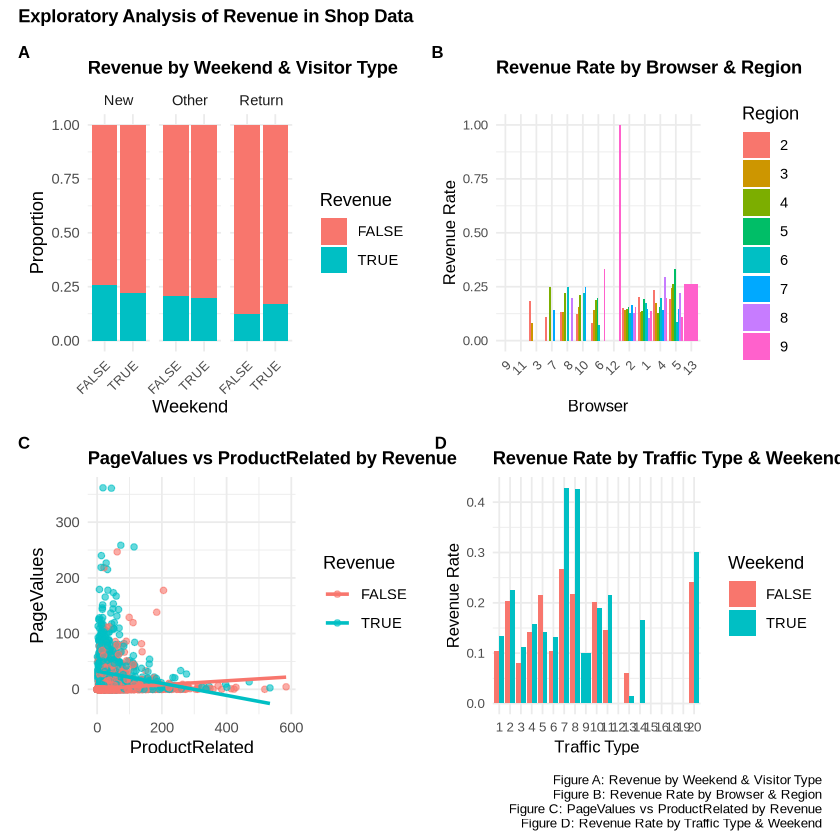

In [11]:
# Combine all plots
multiplot <- (p1 | p2) / (p3 | p4) +
plot_annotation(
title = "Exploratory Analysis of Revenue in Shop Data",
caption = "Figure A: Revenue by Weekend & Visitor Type\nFigure B: Revenue Rate by Browser & Region\nFigure C: PageValues vs ProductRelated by Revenue\nFigure D: Revenue Rate by Traffic Type & Weekend",
tag_levels = 'A' # Automatically labels subplots A, B, C, D
) & theme(
plot.title = element_text(size = 11
                          , face = "bold"),
plot.caption = element_text(size = 8),
plot.tag = element_text(size = 10, face = "bold")
)

multiplot